# S-Wave Prediction

## Global Variables.
This values will be use throughout the algorithm.

SeisLab https://www.mathworks.com/matlabcentral/fileexchange/53109-seislab-3-02?s_tid=FX_rc1_behav

In [1]:
global obj pred num

% obj: Integer. Refers to location of the well log column in the ".LAS" file, that is the target of the prediction.
obj=3;

% pred: Vector. Refers to location of the well logs columns in the ".LAS" file, selected as input to train the model.
pred=[6 7];

% num: Number of independent variables, i.e. size of the vector "pred".
num=size(pred,2);

% Selection of prediction technique.
% 1: Genetic Algorithms using linear equation.
% 2: Genetic Algorithms using polynomial equation.
% 3: Fuzzy Logic.
PREDICCION=3;

## Exploratory Data Analysis

Summarize about ".LAS" format. The information is in this [link](https://www.cwls.org/wp-content/uploads/2017/02/Las2_Update_Feb2017.pdf).

Summarize about "SeisLab3.02" package and the struct returned using "read_las_file". You can download from Mathworks [here](https://www.mathworks.com/matlabcentral/fileexchange/53109-seislab-3-02)

In [2]:
% Add to path:
% Folder with training and test data.
addpath(genpath('Data'))

% Folder with 'SeisLab3.02' package
addpath(genpath('SeisLab3.02'))

% Folder with functions made it to this project
addpath(genpath('Functions'))

% Suppress excess blank lines to show more output on a single screen.
% Default is "loose= Add blank lines to make output more readable."
format compact

### Training Data

Explain that it was selected Well-01 as training data.
Well logs and curves are used as synonyms.

In [3]:
% Well tops definition. They are otherwise known as picks or markers. They define the top and the bottom of the
% stratigraphic unit of interest. 
% Matrix "WELL_TOPS": The 1st row is related to training data and 2nd row to test data.
% WELL_TOPS = [[top bottom] ; 
%             [top bottom]]

WELL_TOPS = [[7297.9702, 7377.0601] ; [8295.0703, 8377.0703]];

In [4]:
% Load training data.
% "read_las_file" in 'SeisLab3.02' package return a structure array with all the information from ".LAS" file
TrainingData=read_las_file('Well-1.LAS');

Log step size not uniform enough; step size changed to 0



<i>"Log step size not uniform enough"</i> means that in this data the sampling interval is not the same in all well logs. The <i>"read_las_file"</i> function returns a structure with many fields, for example:
- <i>"curve_info"</i>. <b>Curve information</b>. It has acronyms, curves names and units in the same order as in ~ASCII log data section.
- <i>"curves"</i>. <b>Data section</b>. ~ASCII data for each well log. All values must be floating point or integer (long) values.
- <i>"step"</i>. Sample interval of the curves.

The index of the data columns is either depth, time, or index. Usually, in well logs <b>the sample interval is a constant equal to 0.5 ft.</b>  Let's see its behavior in 6 rows of data.

In [5]:
% format shortG. Display only 5 digits. 
% Here you can find more information about format -> https://www.mathworks.com/help/matlab/ref/format.html
format shortG

disp(TrainingData.curves(1505:1510,:))

       6890.8          NaN       158.34       86.696          NaN          NaN          NaN
         6891          NaN       156.87       87.286          NaN          NaN          NaN
         6891        2.529          NaN          NaN       0.9701        0.099       0.5123
       6891.2          NaN       155.24       87.794          NaN          NaN          NaN
       6891.5        2.516       153.64       88.135            1       0.0989        0.532
       6891.8          NaN       152.05       88.204          NaN          NaN          NaN



We can see how the function "read_las_file" change the step size in order to put together all well logs and fill empty data with NaN values.

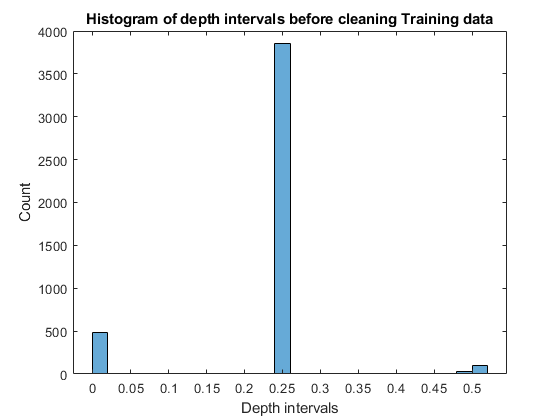

In [6]:
% Substract the next depth value with the previous one and keep into "measureIntervals" vector. 
% This approach tries to avoid for loops, because it's inefficient
measureIntervals = TrainingData.curves(2:end, 1) - TrainingData.curves(1:end-1, 1);

% Plot histogram of depth intervals
histogram(measureIntervals)
title('Histogram of depth intervals before cleaning Training data')
xlabel('Depth intervals')
ylabel('Count')

The sampling intervals is not the same along the well. In most of the depth column is 0.25 ft. It must be 0.5 ft.

In [7]:
% NaN values into Well-01
disp('Percentage of NaN values in training data by curve:')

% Number of rows in Training data matrix
nRows = size(TrainingData.curves,1);

% Compute the percentage of NaN values in each curve.
for item = 2:7
    nan_values = TrainingData.curves(isnan(TrainingData.curves(:,item)), item);
    pNan = (size(nan_values, 1) / nRows) * 100;
    fprintf('%s: %2.2f%%\n', string(TrainingData.curve_info(item, 3)), pNan);
end

Percentage of NaN values in training data by curve:
Density: 53.88%
Delta-T Shear: 13.75%
Delta-T Compressional: 13.75%
Water Saturation: 68.55%
Neutron Porosity: 68.55%
Shale Volume: 68.55%



Here, we can see the <b>high number of NaN values</b> in each curve from Well-01. This could be by:
- A large number of depth intervals without data (gaps).
- NaN values was added to curves by "read_las_file" function, due to step size is not uniform along all the curves.

In order to analyse the first hypothesis, let's plot Density, Delta-T Shear and Shale Volume. The function <i>"plotWellLogs"</i> filter NaN values and include two green lines for well tops.

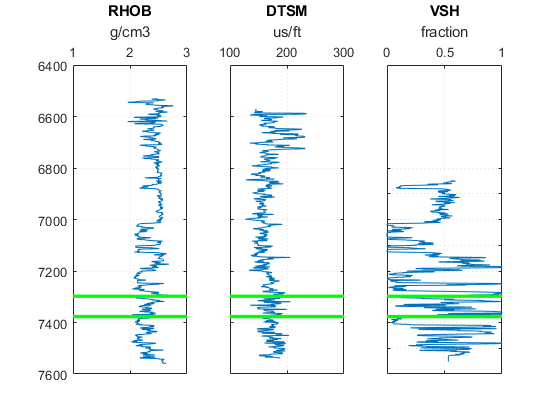

In [8]:
% plotWellLogs(data, wellNames, units, wellTops)
plotWellLogs(TrainingData.curves(:,[1, 2, 3, 7]), ...     % data: [DEPTH, RHOB, DTSM, VSH]
            TrainingData.curve_info([1, 2, 3, 7], 1), ... % wellNames: Column 1 from TrainingData.curve_info
            TrainingData.curve_info([1, 2, 3, 7], 2), ... % units: Column 2 from TrainingData.curve_info
            WELL_TOPS(1,:));

Several observations can be made from this graph:
- The interval measurement of the curves is not the same.
- There is full data into the stratigraphic unit of interest.
- The line curve seems to be continous. There is no visible gaps into the curves.

Therefore, the high percentage of NaN values is because of the difference in sample interval. Thus, the solution is interpolate null values and then filter data only each 0.5 ft.

In [9]:
% function "l_fill_gaps". It interpolates null values of all curves. It assumes that null values are represented by NaN’s.
TrainingData = l_fill_gaps(TrainingData);

% Filter data every 0.5 ft.
% mod(X,b) returns remainder after division of X by b. Here, X is depth column of training data.
% The value "0.5" makes sure to filter only depths ending in 0.0 or 0.5.
TrainingData.curves = TrainingData.curves(mod(TrainingData.curves(:,1), 0.5) == 0,:);

Plot the depth intervals histogram again in order to contrast the difference after cleaning data processing.

After cleaning NaN values and resampling, 98.321% of depth column is sampled at 0.5 ft



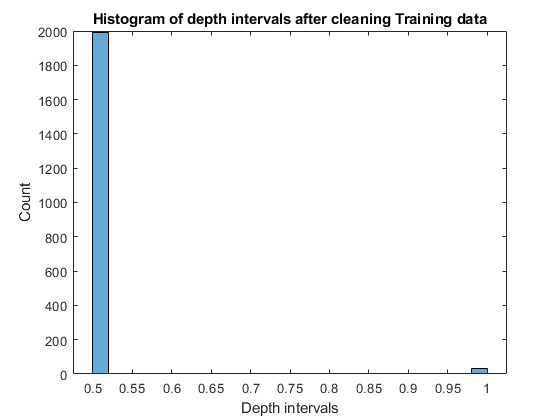

In [10]:
% Substract the next depth value with the previous one and plot histogram this depth intervals.

hist = histogram(TrainingData.curves(2:end, 1) - TrainingData.curves(1:end-1, 1));
title('Histogram of depth intervals after cleaning Training data')
xlabel('Depth intervals')
ylabel('Count')

fprintf('After cleaning NaN values and resampling, %3.3f%% of depth column is sampled at 0.5 ft\n',...
        (hist.Values(1) * 100) / (hist.Values(end) + hist.Values(1)))

Now, let's see the measurement intervals in each curve in order to select data to train the model.

In [11]:
% Print measurement interval of all curves
fprintf('Measurement interval for all curves in %s (Training Data):\n', TrainingData.wellname)
for iCols= 2: size(TrainingData.curves, 2)
    first_index = find(~isnan(TrainingData.curves(:,iCols)), 1, 'first');
    last_index = find(~isnan(TrainingData.curves(:,iCols)), 1, 'last');
    fprintf('%s: (%4.1f - %4.1f) ft\n',  string(TrainingData.curve_info(iCols,3)),...
                                    TrainingData.curves(first_index,1), ...
                                    TrainingData.curves(last_index,1))
end

Measurement interval for all curves in Well-1 (Training Data):
Density: (6530.5 - 7560.0) ft
Delta-T Shear: (6570.0 - 7540.0) ft
Delta-T Compressional: (6570.0 - 7540.0) ft
Water Saturation: (6850.0 - 7552.0) ft
Neutron Porosity: (6850.0 - 7552.0) ft
Shale Volume: (6850.0 - 7552.0) ft



Based on these intervals and well tops location in Well-01, we can select a window 150 ft above and 120 ft below of well tops limits, i.e. an interval depth between 7150 ft - 7500 ft.

There could be the next steps:
- Show the histograms of each well log.
- Crossplots VP-Density and color with Vshale or Porosity or Water Saturation.
- Histogram for shale densities and sand desities and show the difference.
- Plot Box plot and cross plot here in order to see some primary correlations.

### Test Data

Explain that it was selected Well-02 as TEST data. Here, I am going to follow the same analysis than Training data.

In [12]:
% Load training data.
% "read_las_file" in 'SeisLab3.02' package return a structure array with all the information from ".LAS" file
TestData=read_las_file('Well-2.LAS');

Sampling interval does not change along test data and it is equal rougly 0.5 ft. The following histogram show this.

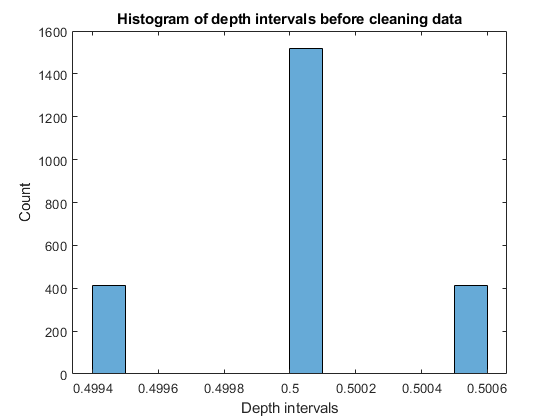

In [16]:
% Substract the next depth value with the previous one and plot histogram of depth intervals
histogram(TestData.curves(2:end, 1) - TestData.curves(1:end-1, 1));
title('Histogram of depth intervals in Test data')
xlabel('Depth intervals')
ylabel('Count')

What's about NaN values in test data?

In [44]:
% NaN values into Well-02
disp('Percentage of NaN values in test data by curve:')

% Number of rows in Training data matrix
nRows = size(TestData.curves,1);

% Compute the percentage of NaN values in each curve.
for item = 2:7
    nan_values = TestData.curves(isnan(TestData.curves(:,item)), item);
    pNan = (size(nan_values, 1) / nRows) * 100;
    fprintf('%s: %2.2f%%\n', string(TestData.curve_info(item, 3)), pNan);
end

Percentage of NaN values in test data by curve:
Density: 0.47%
Delta-T Shear: 0.00%
Delta-T Compressional: 0.00%
Shale Volume: 66.75%
Water Saturation: 66.75%
Neutron Porosity: 66.75%



Percentage of NaN values in Shale Volume, Water Saturation are higher than in the others curves.

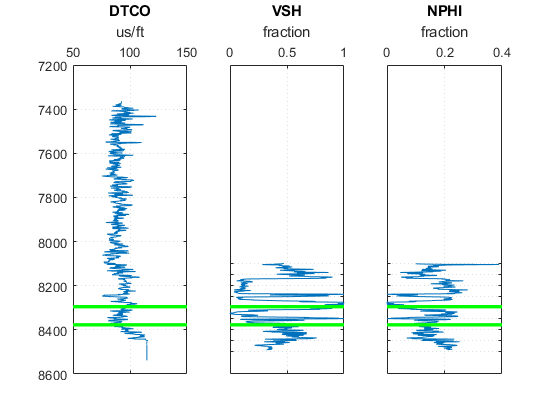

In [37]:
% plotWellLogs(data, wellNames, units, wellTops)
plotWellLogs(TestData.curves(:,[1, 4, 5, 7]), ...     % data: [DEPTH, RHOB, DTSM, VSH]
            TestData.curve_info([1, 4, 5, 7], 1), ... % wellNames.
            TestData.curve_info([1, 4, 5, 7], 2), ... % units.
            WELL_TOPS(2,:));

The high percentage of NaN values in VSH, NPHI and SW curves is due to high gap (depth interval without data) between 7400' and 8100'.

In [42]:
% Interpolate null values with function "l_fill_gaps" only over Density ('rhob') and Delta-T Compressional ('dtco')
TestData = l_fill_gaps(TestData, {'rhob', 'dtco'});

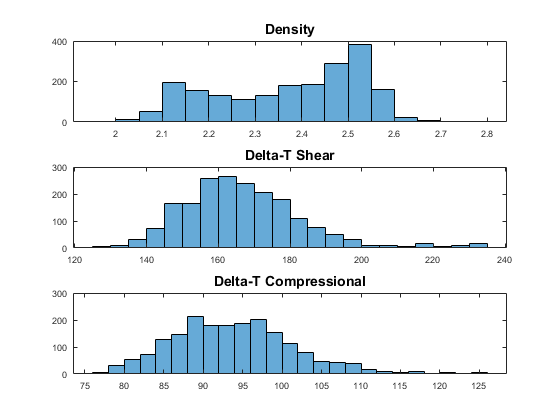

In [63]:
% Plot RHOB, DTCO, DTSM histogram
for item = 1:3
    ax = subplot(3, 1, item);
    histogram(TrainingData.curves(:, item+1));
    ax.FontSize = 7;
    ax.TitleFontSizeMultiplier = 1.5;
    title(TrainingData.curve_info(item+1,3));
end

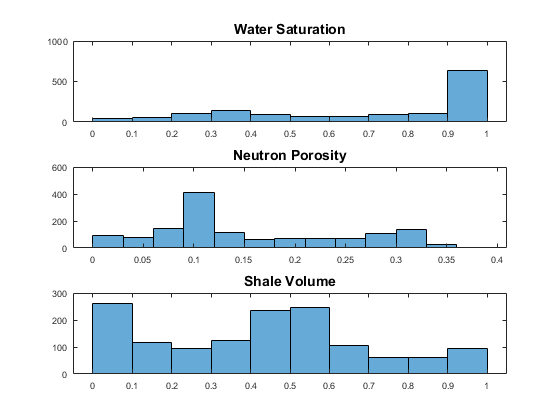

In [64]:
% Plot RHOB, DTCO, DTSM histogram
for item = 1:3
    ax = subplot(3, 1, item);
    histogram(TrainingData.curves(:, item+4));
    ax.FontSize = 7;
    ax.TitleFontSizeMultiplier = 1.5;
    title(TrainingData.curve_info(item+4,3));
end

In [11]:
% Load test data.
Test_data=read_las_file('Well-2.LAS');

In [23]:
% By now, I think this is not important to transform DT data to Velocity.

## Pre-processing data

Check overfitting - underfitting

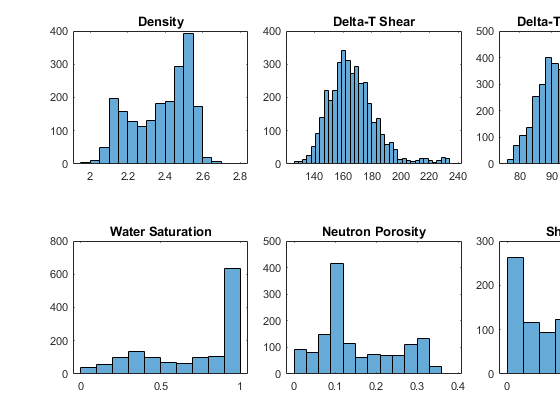

In [8]:
[rows, columns] = size(TrainingData.curve_info);

axis = zeros(6,4);
f = cell(6,1);
for i= 2:rows

    ax = subplot(3, 3, i-1);
    histogram(TrainingData.curves(:, i));
    ax.FontSize = 8;
    ax.TitleFontSizeMultiplier = 1.2;

    f{i-1} = ax;
    axis(i-1, :) = get(ax, 'position');

    title(TrainingData.curve_info(i,3));
end

var = get(f{1}, 'position');
set(f{1}, 'position', var + [0, -0.1, 0.1, 0.1]);

var = get(f{2}, 'position');
set(f{2}, 'position', var + [0.1, -0.1, 0.1, 0.1]);

var = get(f{3}, 'position');
set(f{3}, 'position', var + [0.2, -0.1, 0.1, 0.1]);

var = get(f{4}, 'position');
set(f{4}, 'position', var + [0, -0.3, 0.1, 0.1]);

var = get(f{5}, 'position');
set(f{5}, 'position', var + [0.1, -0.3, 0.1, 0.1]);

var = get(f{6}, 'position');
set(f{6}, 'position', var + [0.2, -0.3, 0.1, 0.1]);